In [28]:
library("dplyr")
library("Seurat")
library("patchwork")
library("ggplot2")
library("clustree")

In [29]:
day7.data = Read10X(data.dir = "../Day7/filtered_feature_bc_matrix/")

day7_Seurat1 = CreateSeuratObject(counts = day7.data, project = "Day7", min.cells = 3, min.features = 2000)
print(day7_Seurat1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
19224 features across 1216 samples within 1 assay 
Active assay: RNA (19224 features, 0 variable features)
 1 layer present: counts


In [30]:
head(day7_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCACACAAGTTC-1,Day7,6939,2676
AAACCCAGTGGGCTCT-1,Day7,6194,2568
AAACGAAAGGCACCAA-1,Day7,16361,3907
AAACGAACAACCAACT-1,Day7,7753,2788
AAACGAAGTTGTTGCA-1,Day7,6697,2473
AAACGAATCAAGCTGT-1,Day7,14757,3494
AAACGCTCATACAGAA-1,Day7,15364,3852
AAACGCTTCCGCTGTT-1,Day7,4412,2154
AAAGAACAGAAACCAT-1,Day7,5909,2371


### Add the percent of mitochondrial genes

In [31]:
# NOTE: only works when using LOWERCASE mt
day7_Seurat1[["percent.mt"]] = PercentageFeatureSet(day7_Seurat1, pattern = "^mt-")
head(day7_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCACACAAGTTC-1,Day7,6939,2676,2.723735
AAACCCAGTGGGCTCT-1,Day7,6194,2568,5.763642
AAACGAAAGGCACCAA-1,Day7,16361,3907,1.735835
AAACGAACAACCAACT-1,Day7,7753,2788,3.895266
AAACGAAGTTGTTGCA-1,Day7,6697,2473,2.583246
AAACGAATCAAGCTGT-1,Day7,14757,3494,3.130718
AAACGCTCATACAGAA-1,Day7,15364,3852,2.408227
AAACGCTTCCGCTGTT-1,Day7,4412,2154,2.674524
AAAGAACAGAAACCAT-1,Day7,5909,2371,2.843121


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


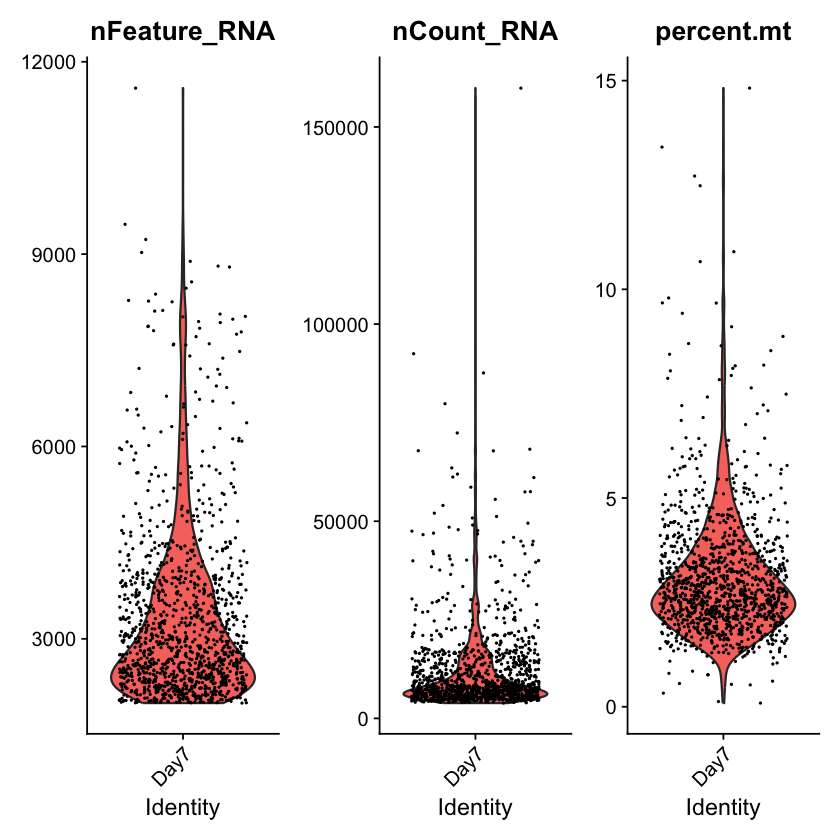

In [32]:
# Visualize QC metrics as a violin plot
# Start here to see the general trend of RNA and Counts
Vln_plots1 = VlnPlot(day7_Seurat1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(Vln_plots1)

In [8]:
pdf(file = "../Day7/figures/Day7_violin_plots.pdf",
    width = 10,
    height = 10)
print(Vln_plots1)
dev.off()

agg_record_1679838478 
                    2

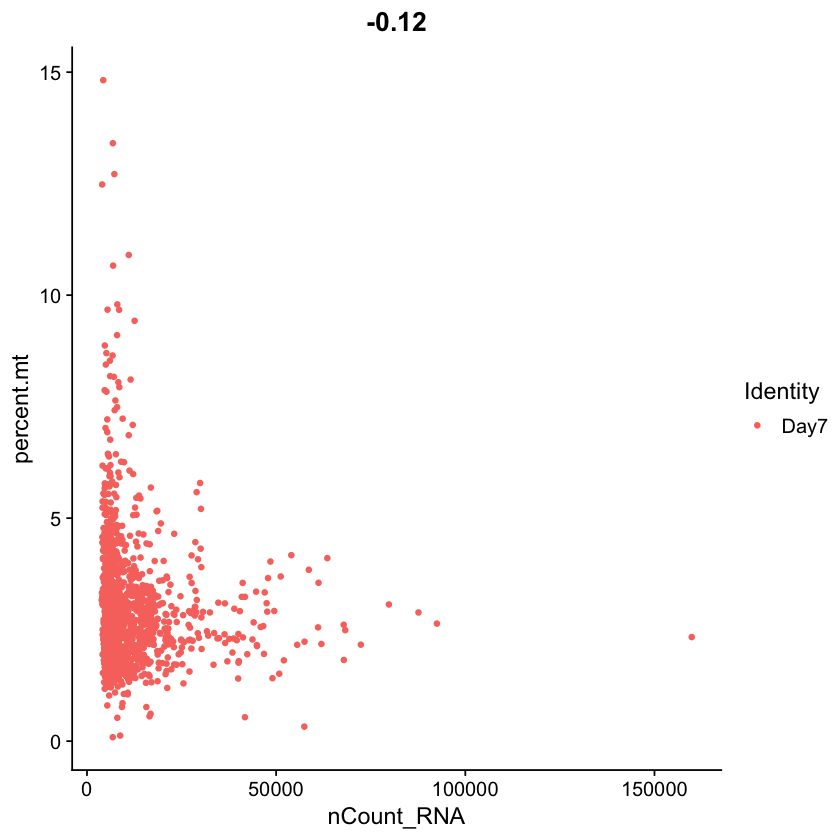

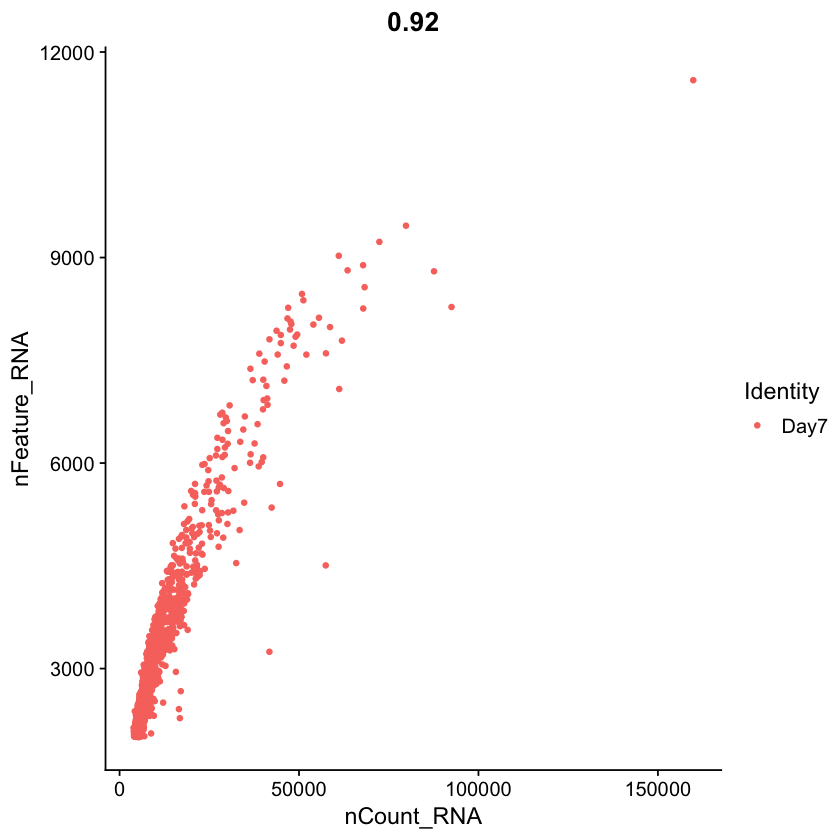

In [6]:
# FeatureScatter is typically used to visualize feature-feature 
# relationships, but can be used for anything calculated by the 
# object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(day7_Seurat1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(day7_Seurat1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
print(plot1)
print(plot2)

In [33]:
# Gather cells samples that have more than 200 genes and less than 5,000. 
# Anything less is most likely empty, anything higher than 5,000 most 
# likely contains more than one cell.
# Remove any cells that have more than 10 percent mitochondrial 
# counts as these are likely artifacts. Cell membrane is compromised 
# or mRNA leakage where only the mitochondrial mRNA remains
day7_Seurat2 <- subset(day7_Seurat1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)

### Normalize the data

In [34]:
day7_Seurat3 = NormalizeData(object = day7_Seurat2, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



### Identification of highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


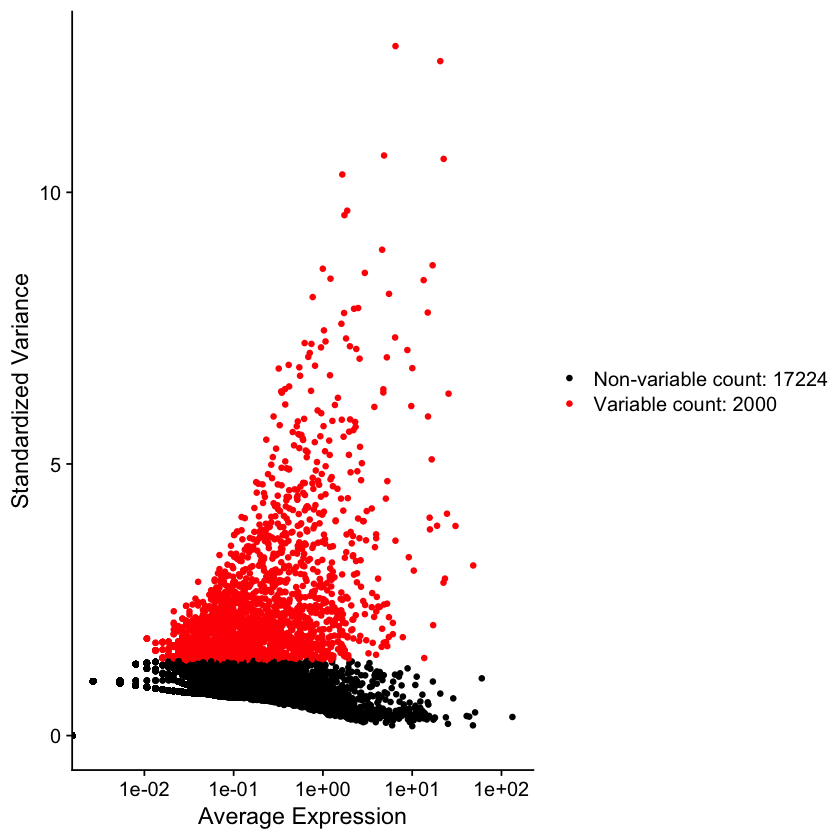

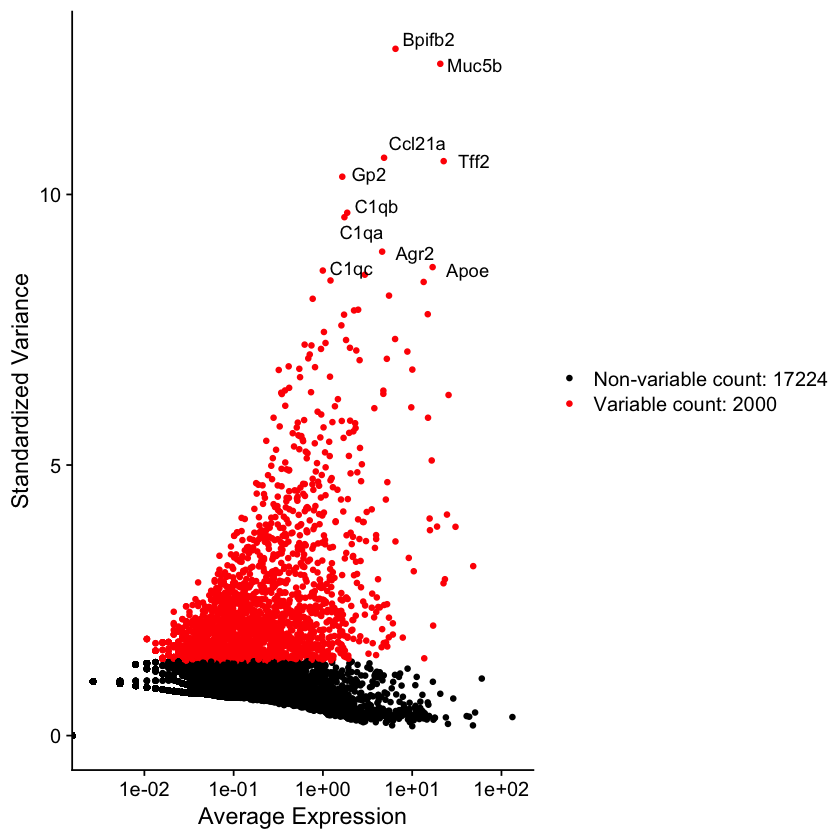

In [35]:
day7_Seurat3 = FindVariableFeatures(day7_Seurat3, selection.method = "vst", nfeatures = 2000)

#plot the top 10 features
top10 = head(VariableFeatures(day7_Seurat3),10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(day7_Seurat3)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

In [26]:
pdf(file = "../Day7/figures/Day7_top_10_VE_genes.pdf",
    width = 10,
    height = 10)
print(plot2)
dev.off()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


agg_record_1219173405 
                    2

In [27]:
#save the top 10 VE genes with their p values
hvf_info = HVFInfo(day7_Seurat3)
top10_genes = head(VariableFeatures(day7_Seurat3), 10)

top10_df = hvf_info[top10_genes, ] %>%
                                  tibble::rownames_to_column(var = "gene")
print(top10_df)
write.csv(top10_df, file = "../Day7/results/top_10_VE_genes_day_7.csv", row.names = FALSE)

     gene       mean    variance variance.expected variance.standardized
1  Bpifb2  6.5013333   990.42179         55.956986             12.691596
2   Muc5b 20.6426667 10246.37999        481.852992             12.414533
3  Ccl21a  4.8426667   815.23989         33.100074             10.677927
4    Tff2 22.5280000 13071.68839        570.721070             10.615402
5     Gp2  1.6480000    62.57630          5.224706             10.328024
6    C1qb  1.8720000    74.58785          6.461108              9.662307
7    C1qa  1.7413333    61.06393          5.726045              9.579654
8    Agr2  4.6080000   543.76304         30.322684              8.943300
9    Apoe 16.9360000  3436.17771        329.562483              8.657277
10   C1qc  0.9973333    20.57486          2.290817              8.593680


### Scaling the data

In [36]:
all.genes = rownames(day7_Seurat3)
day7_Seurat4 = ScaleData(day7_Seurat3, features = all.genes)

Centering and scaling data matrix



In [37]:
# Remove unwanted sources of variation from a single-cell dataset such as mitochondrial contamination.
day7_Seurat4 <- ScaleData(day7_Seurat4, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


### Perform linear dimensional reduction

In [38]:
day7_Seurat5 = RunPCA(day7_Seurat4, features = VariableFeatures(object = day7_Seurat4))

PC_ 1 
Positive:  Ctss, Laptm5, Lyz2, Lcp1, Cd52, Coro1a, Ucp2, Tyrobp, Cd53, Ptprc 
	   Cd74, Fcer1g, Cotl1, H2-Ab1, Ezr, Cybb, Plek, Spi1, Fam49b, Tpd52 
	   H2-Aa, Alox5ap, Rac2, Ctsh, Il1b, H2-Eb1, Cytip, Fyb, Cd14, Cd300c2 
Negative:  Sparc, Bgn, Plpp3, Igfbp7, Col1a2, Mmp2, Serping1, Igfbp4, Col1a1, Serpinf1 
	   Col6a1, Dcn, Col3a1, Col5a2, Prrx1, Lum, Aebp1, Fbln1, Col6a2, Bicc1 
	   Rcn3, C1s1, Cdh11, Ccdc80, Htra1, Il11ra1, Col6a3, Twist1, Mfap2, Fbn1 
PC_ 2 
Positive:  Epas1, Hspb1, Spint2, Tm4sf1, Egfl7, Cdh5, Pecam1, Pcp4l1, Flt1, Emcn 
	   Ecscr, Plvap, Cyyr1, Esam, Ptprb, Ctla2a, Mmrn2, Pdlim1, Adgrf5, Rasip1 
	   Eng, Kdr, Grrp1, Tinagl1, Lrg1, Slco2a1, Apold1, Abcg2, Cd200, Krt8 
Negative:  Tyrobp, Laptm5, Fcer1g, Ctss, Cyba, Ifi30, Plek, Alox5ap, Spi1, Cd53 
	   S100a4, Coro1a, Ptprc, Cd52, Csf1r, Cd300c2, Cd68, Ms4a6c, Il1b, Lsp1 
	   Mpeg1, Pirb, Cd44, H2-DMa, Ctsc, Lcp1, Evi2a, Fyb, Itgb2, Lilrb4a 
PC_ 3 
Positive:  Pecam1, Cdh5, Egfl7, Cd93, Esam, Flt1, Mmrn2, Emc

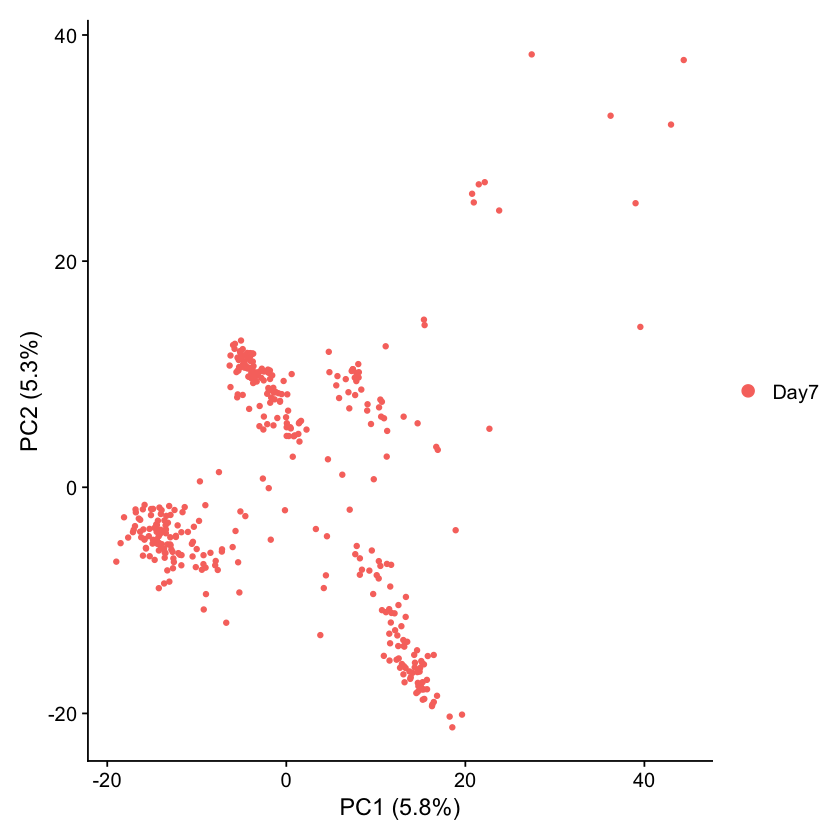

In [40]:
# To add the percent of variation explained by each component
pca_var <- Seurat::Stdev(object = day7_Seurat5, reduction = "pca")
pca_var_perc <- pca_var / sum(pca_var) * 100

pc1_perc <- round(pca_var_perc[1], 1)
pc2_perc <- round(pca_var_perc[2], 1)

PCA_plot1 = DimPlot(day7_Seurat5, reduction = "pca") +
                  xlab(paste0("PC1 (", round(pca_var_perc[1],1), "%)")) +
                  ylab(paste0("PC2 (", round(pca_var_perc[2],1), "%)"))
print(PCA_plot1)

In [41]:
pdf(file = "../Day7/figures/Day7_PCA.pdf",
    width = 10,
    height = 10)
print(PCA_plot1)
dev.off()

agg_record_613098907 
                   2

### Determine the dimensionality of the dataset

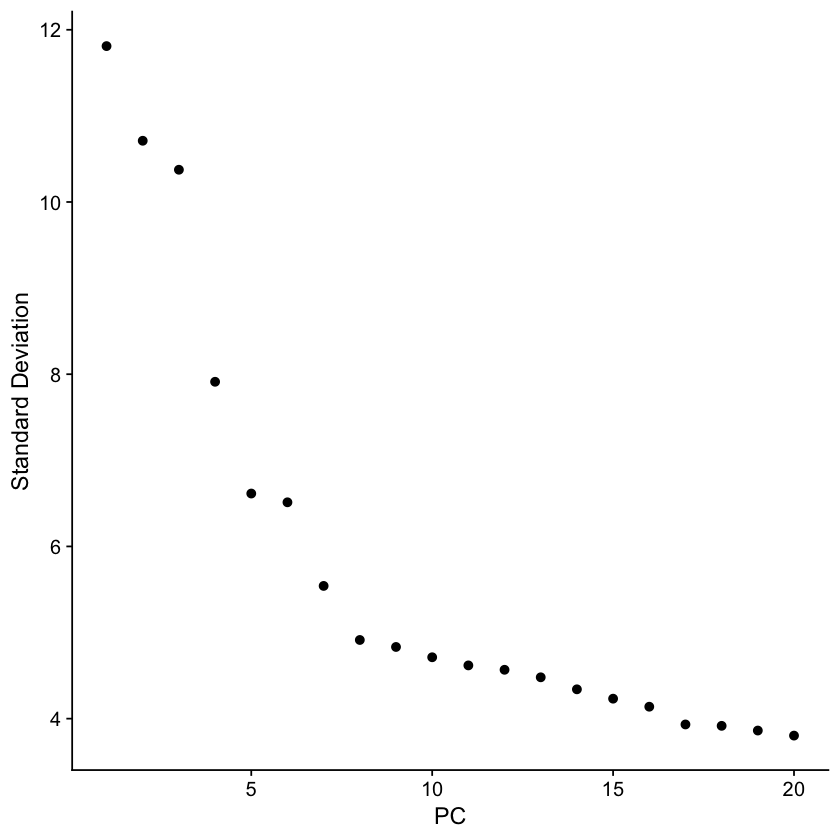

In [39]:
ElbowPlot(day7_Seurat5)

### Cluster the cells

In [42]:
# resolution
# Value of the resolution parameter, use a value above (below) 
# 1.0 if you want to obtain a larger (smaller) number of communities.

day7_Seurat5 = FindNeighbors(day7_Seurat5, dims = 1:50)
day7_Seurat5 = FindClusters(day7_Seurat5, resolution = c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 375
Number of edges: 11947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9390
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 375
Number of edges: 11947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8849
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 375
Number of edges: 11947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8332
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 375
Number of edges: 11947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7897
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version

In [43]:
head(Idents(day7_Seurat5), 5)

AAACGAAGTTGTTGCA-1 AAACGCTTCCGCTGTT-1 AAAGAACAGAAACCAT-1 AAAGGGCAGAAGGTAG-1 
                 9                  7                  7                  3 
AAAGGGCTCTCGGTCT-1 
                 4 
Levels: 0 1 2 3 4 5 6 7 8 9

### Run non-linear dimensional reduction, UMAP

In [44]:
day7_Seurat5 = RunUMAP(day7_Seurat5, dims = 1:50)

11:02:12 UMAP embedding parameters a = 0.9922 b = 1.112

11:02:12 Read 375 rows and found 50 numeric columns

11:02:12 Using Annoy for neighbor search, n_neighbors = 30

11:02:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:02:12 Writing NN index file to temp file /var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//RtmpgFdz7g/file8666ac688c2

11:02:12 Searching Annoy index using 1 thread, search_k = 3000

11:02:12 Annoy recall = 100%

11:02:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:02:12 Initializing from normalized Laplacian + noise (using RSpectra)

11:02:12 Commencing optimization for 500 epochs, with 13406 positive edges

11:02:12 Using rng type: pcg

11:02:12 Optimization finished



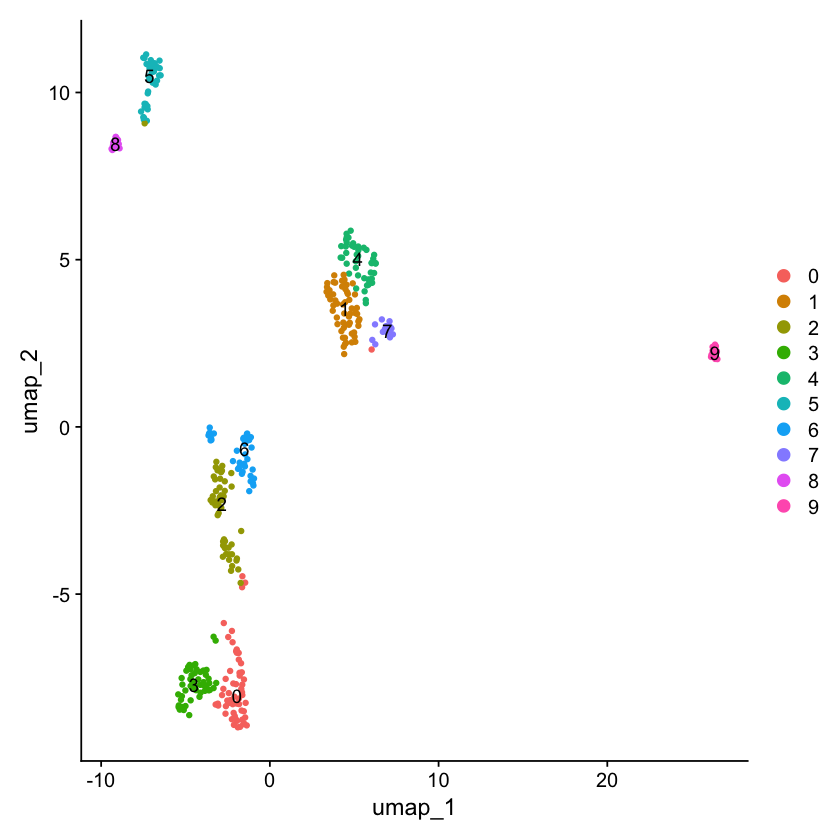

In [45]:
UMAP_plot1 = DimPlot(day7_Seurat5, reduction = "umap", label = TRUE)
print(UMAP_plot1)

In [46]:
pdf(file = "../Day7/figures/Day7_UMAP_plot.pdf",
    width = 10,
    height = 10)
print(UMAP_plot1)
dev.off()

agg_record_1472604383 
                    2

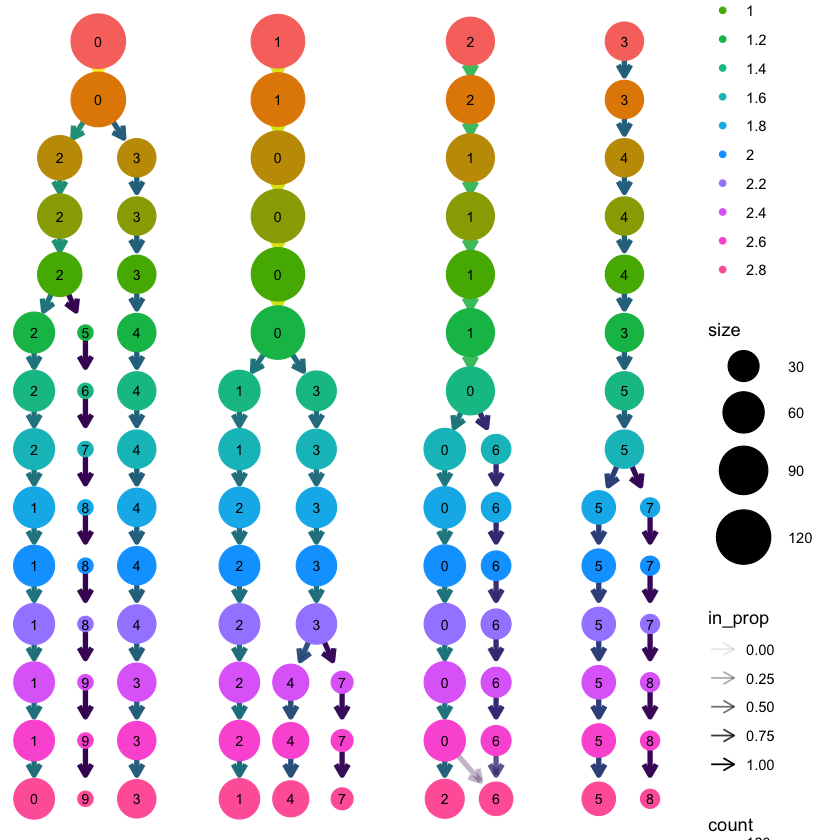

In [47]:
phylo_tree1 = clustree(day7_Seurat5, prefix = "RNA_snn_res.")
print(phylo_tree1)

In FindClusters(), resolution controls how finely the shared-nearest-neighbor (SNN) graph is cut:<br>
lower resolution → fewer, larger clusters<br>
higher resolution → more, smaller clusters<br>
Each column in clustree is a resolution. Each node is a cluster at that resolution.

In [48]:
pdf(file = "../Day7/figures/Day7_phylogenetic_tree.pdf",
    width = 10,
    height = 10)
print(phylo_tree1)
dev.off()

agg_record_1292448449 
                    2

In [24]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Tahoe 26.0.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] future_1.68.0      clustree_0.5.1     ggraph_2.2.2       ggplot2_4.0.1     
[5] patchwork_1.3.2    Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
[9] dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.4        
  [4] spatstat.utils_3.2-0   farver_2.1.2           ragg_1.5.0            
  [7] vctrs_0.6.5            ROCR_1.0-11    